In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn
seaborn.set()
import time
from tqdm import tqdm
from scipy.stats import pearsonr

print('done')

%load_ext autoreload
%autoreload 2

done


In [2]:
import torch
# Check GPU availability
use_gpu = torch.cuda.is_available()
dtype = torch.cuda.FloatTensor if use_gpu \
        else torch.FloatTensor

C:\Users\Alexandra\anaconda3\lib\site-packages\torch\cuda\__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  ..\c10\cuda\CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


In [3]:
# small function to plot images
def showTensor(aTensor, pos=111):
    plt.subplot(int(pos))
    plt.imshow(aTensor)    #,cmap='viridis')
    plt.colorbar()
    #plt.show()
    plt.rcParams["axes.grid"] = False

In [4]:
# Functions to create complex tensors (ie, split real & img parts) + transfer between numpy and pytorch

def to_complex_tensor(stuff):
    # TO_COMPLEX_TENSOR transforms a complex nparray into a complex tensor
    # The real and imaginary part are concatenated along the last dimension
    
    # Retrieve real and imaginary parts in separate tensors
    stuff_r = torch.from_numpy(np.real(stuff)).type(dtype)
    stuff_i = torch.from_numpy(np.imag(stuff)).type(dtype)
    # Add a last dimension
    stuff_r = torch.unsqueeze(stuff_r, dim=stuff_r.ndimension())
    stuff_i = torch.unsqueeze(stuff_i, dim=stuff_i.ndimension())
    # Return the concatenation
    return torch.cat((stuff_r, stuff_i), dim=-1)

def from_complex_tensor(stuff):
    # FROM_COMPLEX_TENSOR transforms a complex tensor into a complex nparray
    
    # Retrieve real and imaginary parts in separate tensors
    (stuff_r, stuff_i) = torch.chunk(stuff, 2, dim=-1)
    # Convert to numpy
    stuff_r = np.squeeze(stuff_r.cpu().detach().numpy())
    stuff_i = np.squeeze(stuff_i.cpu().detach().numpy())
    # Return the complex-valued nparray
    return stuff_r + 1j * stuff_i

In [5]:
# Functions to compute complex tensors (eg: tensor muliplication) which are not implemented in Pythorch

def complex_matmul(a, b):
    # COMPLEX_MATMUL computes a@b with a and b complex

    # Retrieve real and imaginary parts in separate tensors
    (a_r, a_i) = torch.chunk(a, 2, dim=-1)
    (b_r, b_i) = torch.chunk(b, 2, dim=-1)
    # Remove the last dimension
    a_r = torch.squeeze(a_r)
    a_i = torch.squeeze(a_i)
    b_r = torch.squeeze(b_r)
    b_i = torch.squeeze(b_i)
    # Compute the multiplication
    real_part = a_r @ b_r - a_i @ b_i
    imag_part = a_i @ b_r + a_r @ b_i
    # Return the concatenation
    return torch.cat((real_part.unsqueeze_(-1), imag_part.unsqueeze_(-1)), dim=-1)
#     return torch.cat((real_part[:, np.newaxis], imag_part[:, np.newaxis]), dim=-1)

def complex_multiply(a, b):
    # COMPLEX_MULTIPLY computes a*b with a and b complex

    # Retrieve real and imaginary parts in separate tensors
    (a_r, a_i) = torch.chunk(a, 2, dim=-1)
    (b_r, b_i) = torch.chunk(b, 2, dim=-1)
    # Remove the last dimension
    a_r = torch.squeeze(a_r)
    a_i = torch.squeeze(a_i)
    b_r = torch.squeeze(b_r)
    b_i = torch.squeeze(b_i)
    # Compute the multiplication
    real_part = a_r * b_r - a_i * b_i
    imag_part = a_i * b_r + a_r * b_i
    # Return the concatenation
    return torch.cat((real_part.unsqueeze_(-1), imag_part.unsqueeze_(-1)), dim=-1)

def complex_norm2(b):
    # COMPLEX_NORM2 computes the L2 norm square of b
    return torch.sum(b**2)

In [6]:
def phase_to_complex(phi):
    # PHASE_TO_COMPLEX transforms a real-valued tensor into a complex tensor
    # Compute the real and imaginary parts in separate tensors    
    stuff_r = torch.cos(phi)
    stuff_i = torch.sin(phi)
    # Add a last dimension
    stuff_r = torch.unsqueeze(stuff_r, dim=stuff_r.ndimension())
    stuff_i = torch.unsqueeze(stuff_i, dim=stuff_i.ndimension())
    # Return the concatenation
    return torch.cat((stuff_r, stuff_i), dim=-1)

# Incoherent Process (eg: Fluorescence)

### Forward Model

In [7]:
Npat = 2000 # nb of patterns on the SLM
Nslm = 256  # nb of SLM pixels
Nfluo = 3   # nb of beads
Ncam = 256  # nb of camera pixels

T1 = np.random.randn(Nfluo,Nslm) +1j * np.random.randn(Nfluo,Nslm)
T2 = abs(np.random.randn(Ncam,Nfluo))
T1_t = to_complex_tensor(T1)
T2_t = torch.from_numpy(T2).float()

SLM_input = np.random.rand(Nslm, Npat) * 2 * np.pi
SLM_input = torch.from_numpy(SLM_input).type(dtype)
SLM_input_t = phase_to_complex(SLM_input)

field1_t = complex_matmul(T1_t, SLM_input_t)
int1_t = torch.sum(torch.abs(field1_t)**2,-1)
CAM_output_t = T2_t@int1_t

### Gradient Descent

In [8]:
## Initialization
est_T1 = np.random.randn(Nfluo,Nslm) + 1j*np.random.randn(Nfluo,Nslm)
est_T2 = abs(np.random.randn(Ncam,Nfluo))
est_T1_t = to_complex_tensor(est_T1)
est_T2_t = torch.from_numpy(est_T2).float()

# Declare what are the parameters to optimize
est_T1_t.requires_grad = True
est_T2_t.requires_grad = True

# other parameters
n_iter = 1000
loss_vec = np.zeros(n_iter)
cc1_mean = np.zeros(n_iter)
cc2_mean = np.zeros(n_iter)
cc22_mean = np.zeros(n_iter)
tau = 0.5
c = 0.9

for i_iter in tqdm(range(n_iter)):
    # Estimation of camera image
    est_field1_t = complex_matmul(est_T1_t, SLM_input_t)
    est_int1_t = torch.sum(torch.abs(est_field1_t)**2,-1)
    est_CAM_output_t = est_T2_t@est_int1_t
    # Loss computation
    loss = complex_norm2(est_CAM_output_t - CAM_output_t)
    loss_vec[i_iter] = loss
    # Gradient computation
    loss.backward(retain_graph = True)
    # Gradient descent with backtracking
    lr0 = 1e-8
    lr = lr0  # learning rate
    with torch.no_grad():
        m = - torch.norm(est_T1_t.grad)
        while True:
            # new estimate
            new_est_T1_t = est_T1_t - lr * est_T1_t.grad
            new_est_T2_t = abs(est_T2_t - lr * est_T2_t.grad) # T2 should be positive with Fluorescence
            # new error with this new estimate
            new_est_field1_t = complex_matmul(new_est_T1_t, SLM_input_t)
            new_est_int1_t = torch.sum(torch.abs(new_est_field1_t)**2,-1)
            new_est_CAM_output_t = new_est_T2_t@new_est_int1_t
            new_loss = complex_norm2(new_est_CAM_output_t - CAM_output_t)
            if loss - new_loss >= c * lr * m:
                break
            else:
                lr *= tau
                
        est_T1_t -= lr * est_T1_t.grad
        est_T2_t -= lr * est_T2_t.grad
            
    # Reset gradients
    est_T1_t.grad.zero_()
    est_T2_t.grad.zero_()
    
    # correlation matrix
    r_T1 = from_complex_tensor(est_T1_t)
    r_T2 = est_T2_t.detach().numpy()
    corel1 = np.zeros((Nfluo , Nfluo),dtype=float)
    corel2 = np.zeros((Nfluo , Nfluo),dtype=float)
    corel22 = np.zeros((Nfluo , Nfluo),dtype=float)
    for tt in  np.arange(0,Nfluo,1):
        for jj in  np.arange(0,Nfluo,1):
            corel1[tt,jj] = np.abs(np.conj(T1[tt,:]).T @ r_T1[jj,:]) / (np.linalg.norm(T1[tt,:])*np.linalg.norm(r_T1[jj,:]))
            corel2[tt,jj] = np.abs(np.conj(T2[:,tt]).T @ r_T2[:,jj]) / (np.linalg.norm(T2[:,tt])*np.linalg.norm(r_T2[:,jj]))
            corel22[tt,jj] = np.corrcoef(T2[:,tt],r_T2[:,jj])[1,0]
            
    cc1 = np.reshape( corel1 , (1, Nfluo*Nfluo))
    idex = (-cc1).argsort()[:Nfluo]
    cc1_mean[i_iter] = np.mean(cc1[0,idex[0,:Nfluo]])
    cc2 = np.reshape( corel2 , (1, Nfluo*Nfluo))
    idex = (-cc2).argsort()[:Nfluo]
    cc2_mean[i_iter] = np.mean(cc2[0,idex[0,:Nfluo]])
    cc22 = np.reshape( corel22 , (1, Nfluo*Nfluo))
    idex = (-cc22).argsort()[:Nfluo]
    cc22_mean[i_iter] = np.mean(cc22[0,idex[0,:Nfluo]])

100%|██████████| 1000/1000 [01:18<00:00, 12.73it/s]


### Results

Learning Rate:   lr_init =  1e-08   -->  lr_final =  3.814697265625e-14
Loss minimization:   loss_final / loss_ init  =   9.468561260772257e-14


Text(0, 0.5, 'Correl T2')

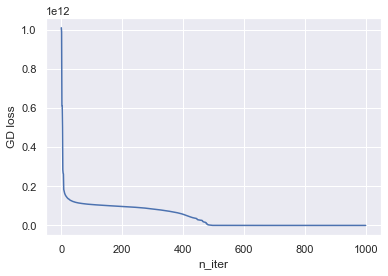

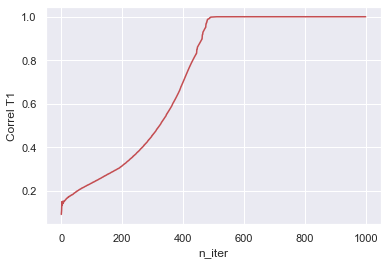

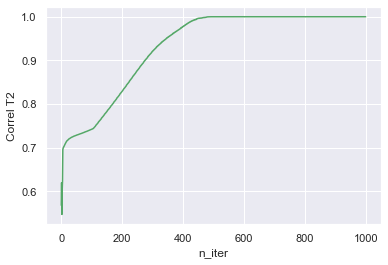

In [9]:
# How good is the reconstruction of the two TMs T1 (SLM <-> beads) and T2 (beads <-> CAM) ?

print('Learning Rate:   lr_init = ', lr0, '  -->  lr_final = ', lr)
print('Loss minimization:   loss_final / loss_ init  =  ', loss_vec[-1] / loss_vec[0])

plt.figure()
plt.plot(loss_vec)
plt.xlabel('n_iter')
plt.ylabel('GD loss')
plt.figure()
plt.plot(cc1_mean,'r')
plt.xlabel('n_iter')
plt.ylabel('Correl T1')
plt.figure()
plt.plot(cc22_mean,'g')
plt.xlabel('n_iter')
plt.ylabel('Correl T2')